# SacCer3 TF-nucleosome ChromWave

In this notebook we show how to load and pre-processes sacCer3 MNase-seq data (Henikoff et al 2011) and trained ChromWave model. We compute in silico mutagenesis scores and saliency maps which we visualise using the DNA sequence of the GAL4 UAS as in Figure 2E.

In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy
import pandas
import sys
from chromwave import runtime_dataset, filesystem, chromwavenet, vis

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

## Setting up the directories

You'll need the data in the repository, please make sure you've cloned it and the working directoy points to it.

In [3]:
# working directory should be ChromWave/scripts/Tutorials_Workflows. if not change project dir to be the directory 
# containing the code for ChromWave
project_dir = os.path.abspath(os.path.join(os.getcwd(),'../../../'))
working_dir = os.path.join(project_dir, 'ChromWave')
output_dir = os.path.join(project_dir,'Test')

In [4]:
data_dir = os.path.join(working_dir, 'data')
model_dir = os.path.join(working_dir, 'models')

TF_profile1=os.path.join(data_dir,'henikoff2011','nuclei_20min_rep1_nucFree_fpm.bed')
TF_profile2=os.path.join(data_dir,'henikoff2011','nuclei_20min_rep2_nucFree_fpm.bed')
nuc_profile1=os.path.join(data_dir,'henikoff2011','nuclei_20min_rep1_monoNuc_fpm.bed')
nuc_profile2=os.path.join(data_dir,'henikoff2011','nuclei_20min_rep2_monoNuc_fpm.bed')



model_dir = os.path.join(model_dir,'tf-nucleosome/sacCer3')


# Loading the data

We first set up the FileSystem, passing the location of the genome fa files, the output directory and nucleosome profiles of the in vitro profiles of the Kaplan et al 2009 data. If the output folder was already created wwe will overwrite as this instance. We have no test data to pass and we split the dataset into 20% test and 10% validation data (and 80% training data). 

We then load the data as a RuntimeDataset object with the underlying FileSystem. The sequences in the training, test and validation data will be shuffled but for testing purposes we use a fixed seed. We include the reverse complements of each sequence and remove sequences if a third of the region has a flat signal. The class weight cap denotes the max at which the class weights (computed as median/frequency per class) are capped to avoid extremely high weights for rarely occuring classes. 

In [5]:
u = [10, 5]
source_profiles=[TF_profile1, nuc_profile1]
tf_preprocessing_params = {'times_median_coverage_max': 3, 'u': u[0], 'smooth_signal': True,
                            'sigma': 5, 'truncate': 3,
                           'smoothing_function': 'gaussian_filter1d', 
                           'normalise_read_counts': 'genome_mean'}
nuc_preprocessing_params = {'times_median_coverage_max': 3,'u': u[1], 'smooth_signal': True,
                            'sigma': 5, 'truncate': 3,
                            'smoothing_function': 'gaussian_filter1d',
                            'normalise_read_counts': 'genome_mean'}
preprocessing_params  = [tf_preprocessing_params,nuc_preprocessing_params]


In [6]:
f = filesystem.FileSystem(os.path.join(data_dir,'genomes/sacCer3'), os.path.join(output_dir,'Saliency'), source_profile=source_profiles, overwrite=True, resume=False)
r = runtime_dataset.RuntimeDataset(f)
r.data_format='raw_counts'
r.preprocessing_params=preprocessing_params
r.fragment_length =5000
r.load_data()


Loading genomic data... 
Mitochondrial chromosome will be kept as separate data...
using pre-processing params:
{'times_median_coverage_max': 3, 'u': 10, 'smooth_signal': True, 'sigma': 5, 'truncate': 3, 'smoothing_function': 'gaussian_filter1d', 'normalise_read_counts': 'genome_mean'}


/home/cakiroa/projects/ChromWave_python3/chromwave/functions/signal_processing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_data_frame.dropna(axis=0, inplace=True)


Normalising read counts by subtracting the genome mean
using pre-processing params:
{'times_median_coverage_max': 3, 'u': 5, 'smooth_signal': True, 'sigma': 5, 'truncate': 3, 'smoothing_function': 'gaussian_filter1d', 'normalise_read_counts': 'genome_mean'}
Normalising read counts by subtracting the genome mean
Binding profiles were binned into [3, 5] bins.


# Loading the models

We start by loading the in vivo and in vitro nucleosome models from the model directory

In [7]:
TFNUC_model =  chromwavenet.ChromWaveNet()
TFNUC_model.deserialize(directory = model_dir)

Receptive Field: 4093 


The following plots the model architecture to the model directory

In [8]:
TFNUC_model.plot_model(directory=model_dir)

# GAL 4 UAS analysis

We first select the region of interest (e.g. GAL4 UAS, see Figure 2E) and extract the genomic sequence (padded to 4000bp):

In [9]:
prom_chr='chrII'
UAS_start = 278352
UAS_end = 279021
prom_start=UAS_start -500
prom_end=5000+prom_start
x=r.genome_data[r.chr_info.index(prom_chr)][:,prom_start:prom_end]
x=numpy.expand_dims(numpy.swapaxes(x,0,1),0)
print(x.shape)

(1, 5000, 4)


Let's look at the predictions of ChromWave on the UAS site. To predict we are using the ChromWave function `predict_smooth` to postprocess the predicted classes into smoothed binding profiles. 

Let's plot the predictions 500bp up- to 1000bp downstream ofthe start of the UAS site: 

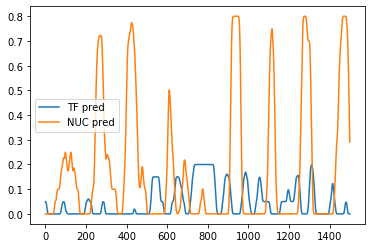

In [10]:
smoothed_predictions_UAS = TFNUC_model.predict_smooth(x)

pandas.DataFrame(numpy.vstack(smoothed_predictions_UAS)[:,:1500].transpose(), columns=['TF pred', 'NUC pred']).plot(subplots=False)
plt.show()

Let's plot the data +/- 500bp around the start of the UAS site to compare with the predictions:

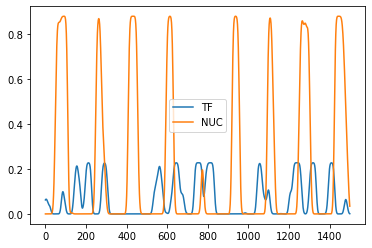

In [11]:
profiles=[r.profile_data_smooth[i][r.chr_info.index(prom_chr)][prom_start:(prom_start+1500)] for i in range(len(r.profile_data_smooth))]
pandas.DataFrame(numpy.vstack(profiles).transpose(), columns=['TF', 'NUC']).plot(subplots=False)
plt.show()

# In silico mutagenesis scores

We then use the functions of the ChromWave models to compute the in silico mutagenesis scores - we have 2 output profiles and `x_mut` is a list with 2 elements (which themselves are lists storing the differences in predicitons in the first entry). 

In [12]:
x_mut = TFNUC_model.in_silico_mutagenesis(x)

ISM: sample:0
ISM: sample:0


In [13]:
x_mut[0][0].shape

(1, 5000, 5000, 4)

In [14]:
x_mut[1][0].shape

(1, 5000, 5000, 4)

The function returns a list of arrays: the difference in predictions between base change and WT, the predictions for each base change, the preactivations for each base change, and the difference of preactivations for each base change and WT. For sample 0, first base, the predictions of all possible basechanges in the TF profile are held in:

In [15]:
x_mut[0][0][0,0,:,:]

array([[ 0.        , -0.00062698,  0.        ,  0.        ],
       [ 0.        , -0.00097374,  0.        ,  0.        ],
       [ 0.        , -0.0016837 ,  0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [16]:
predictions_mut_TF = x_mut[0][0]
predictions_mut_NUC = x_mut[1][0]

The ISM scores for a specific segment of the sequence is then computed as sum along axis 2 within the range we are interested in - here we do it along the whole sequence of the UAS site. The output array is of shape `[1,len_seq,num_bases]` and can be visualised as a heatmap downstream. 

In [17]:
UAS_len = UAS_end - UAS_start
min=500
max=(500+UAS_len)
# sum of delta within region min:max achievable by each base mutation
sumdelta_per_base_mut_TF = numpy.sum(predictions_mut_TF[:,:,min:max,:],2)
sumdelta_per_base_mut_NUC = numpy.sum(predictions_mut_NUC[:,:,min:max,:],2)

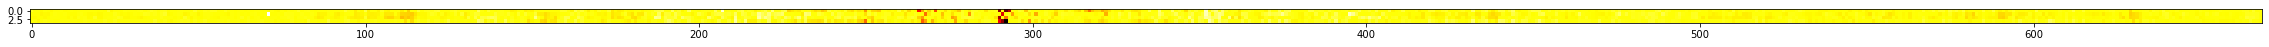

In [29]:
fig=plt.figure(figsize=(40,30))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(numpy.squeeze(sumdelta_per_base_mut_TF,0)[min:max,:].transpose(), cmap='hot')
plt.show()

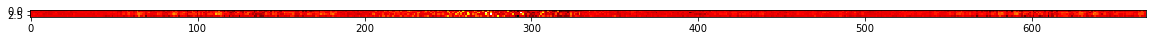

In [19]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(numpy.squeeze(sumdelta_per_base_mut_NUC,0)[min:max,:].transpose(), cmap='hot')
plt.show()

To find the maximal gain and losses in the profile at each position given all possible base changes along the sequence to identify dynamic nucleosome binding 'hotspots' we can do:

In [20]:
# max achievable changes mutating the each base
maxdelta_profile=numpy.max(numpy.max(predictions_mut_NUC,axis=1),-1)
# min achievable changes mutating the each base
mindelta_profile=numpy.min(numpy.min(predictions_mut_NUC,axis=1),-1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f240c21af90>,
      dtype=object)

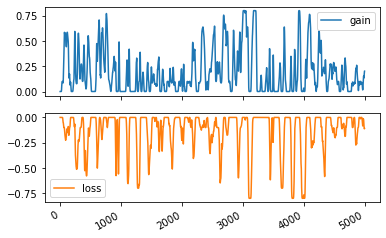

In [21]:
pandas.DataFrame(numpy.vstack([maxdelta_profile,mindelta_profile]).transpose(), columns=['gain','loss']).plot(subplots=True)

# Saliency maps

ChromWave models can compute the saliency maps for each output profile for certain positions (or ranges). Note that the function `compute_saliency` returns a list of arrays, so to save with numpy use `numpy.savez` as indicated below. 

In [22]:
# Saliency scores for the UAS site: padded from left by 500bp
UAS_len = UAS_end - UAS_start
min=500
max=(500+UAS_len)
saliceny_scores_for_seq = TFNUC_model.compute_saliency(sequence_data = x,min=min,max=max)
# 
#numpy.savez( os.path.join(directory,Promoter_name+'scores.npz'), *scores_for_seq)

The 2 saliency maps for each of the profiles is held as list in `saliency_scores_for_seq`. 

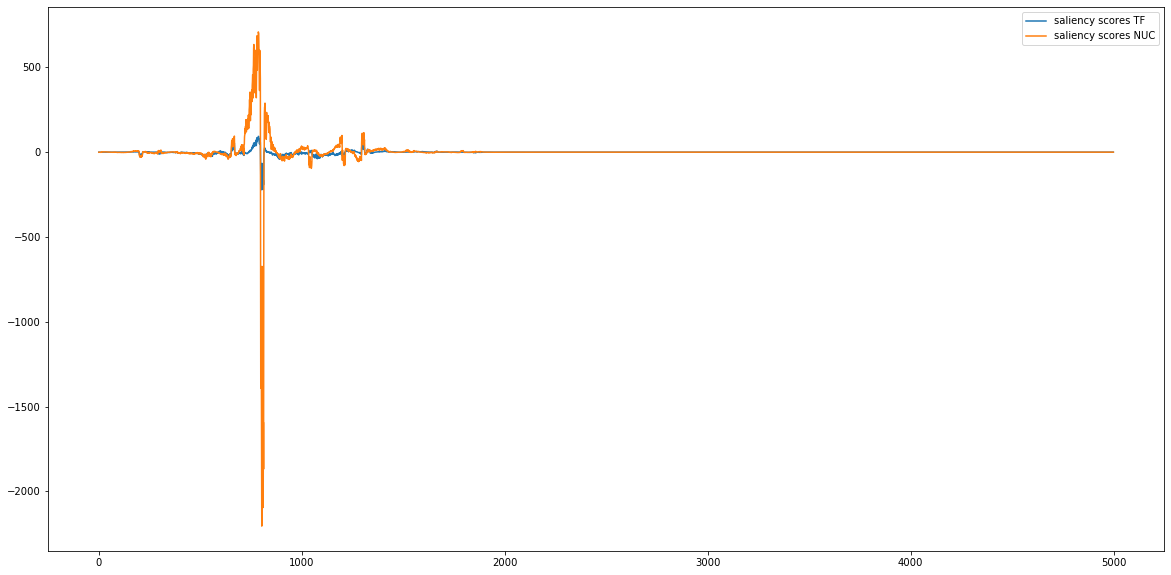

In [23]:
pandas.DataFrame(numpy.stack([numpy.squeeze(numpy.sum(s,-1),0) for s in saliceny_scores_for_seq]).transpose(),columns=['saliency scores TF', 'saliency scores NUC']).plot(figsize=(20,10))

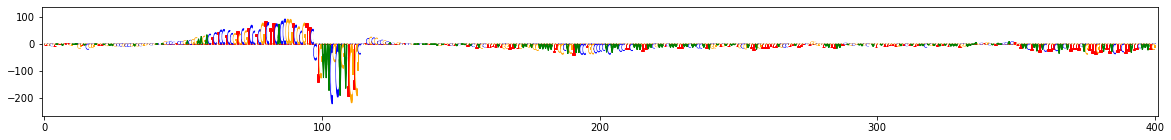

In [24]:
from chromwave.vis import viz_sequence
viz_sequence.plot_weights(saliceny_scores_for_seq[0][:, (min+200):(min+600), :], subticks_frequency=100)

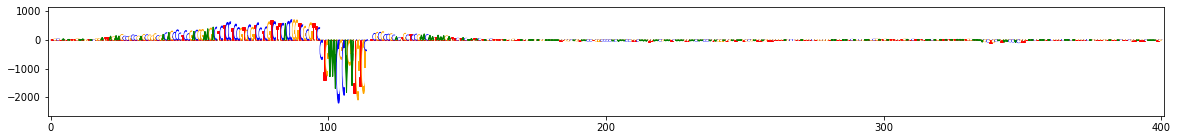

In [25]:
viz_sequence.plot_weights(saliceny_scores_for_seq[1][:, (min+200):(min+600), :], subticks_frequency=100)

# Cutting out the RSC-binding site

 The RSC motif is within the UAS site across the 273-333 basepairs. Here, as we have padded the UAS site with 500bp from left, we delete the base positions (500+273)-(500+334) to include bp 500+333. 

In [26]:
x_noRSC=numpy.delete(x, slice(500+272, 500+ 334), axis=1)

As before we can compute the predictions across this truncated sequence and plot the result. 

Receptive Field: 4093 
Receptive Field: 4093 


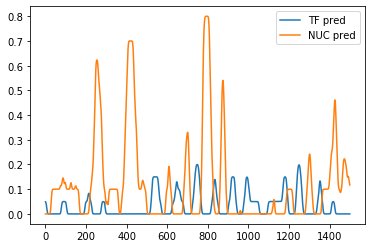

In [27]:
smoothed_predictions_UAS_noRSC=TFNUC_model.predict_smooth(x_noRSC) # predict returns the one-hot encoded signal
pandas.DataFrame(numpy.vstack(smoothed_predictions_UAS_noRSC)[:,:1500].transpose(), columns=['TF pred', 'NUC pred']).plot(subplots=False)
plt.show()

# Cutting out the GAL4 binding site

There are 3 GAL4 motifs in the 57 bp upstream of the previously cutout region - cutting these 57bp now.


Receptive Field: 4093 
Receptive Field: 4093 


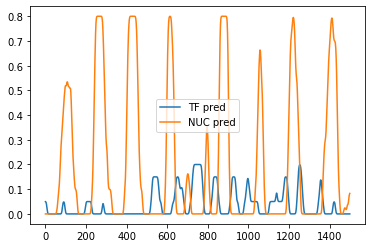

In [28]:
x_noGAL4=numpy.delete(x, slice(500+272-57, 500+272 +1), axis=1)
smoothed_predictions_UAS_noGAL4=TFNUC_model.predict_smooth(x_noGAL4) # predict returns the one-hot encoded signal
pandas.DataFrame(numpy.vstack(smoothed_predictions_UAS_noGAL4)[:,:1500].transpose(), columns=['TF pred', 'NUC pred']).plot(subplots=False)
plt.show()